<h1><center>Machine Learning-basierte Extraktion von phänotypischen Kennzahlen aus UAV-Bildern</center></h1>



<h3><center> head_detection.ipynb: Blumenkohlkopf Erkennung, Größe des Kopfes </center></h3>


Dieses Notebook beschreibt die Schritte zur Erkennung des Kopfes in der Blumenkohlpflanze und zur Berechnung seiner Größe, von der Datenorganisation bis zum Trainingsprozess des Objekterkennungsalgorithmus.

## Initialisieren der Arbeitsumgebung

In [28]:
# Dieser Befehl führt das YOLOv5-Erkennungsskript direkt in einem Jupyter-Notebook aus.
# Er muss als erste Zelle ausgeführt werden, um die YOLO-Umgebung im Notebook korrekt einzurichten.
# Wenn irgendetwas anderes vor dieser Zeile ausgeführt wird, funktioniert der YOLO-Algorithmus möglicherweise nicht korrekt,
# und es könnte notwendig sein, die Umgebung im Notebook zurückzusetzen. Der genaue Grund dafür ist unklar,
# aber es ist wichtig, diesen Schritt zu befolgen, um sicherzustellen, dass YOLO wie erwartet funktioniert.
%run yolov5/detect.py --weights yolov5/runs/train/exp10/weights/best.pt --img 256 --conf 0.5 --source yolov5/test_infer/2021_08_30_post_Def_day4_111.jpg

detect: weights=['yolov5/runs/train/exp10/weights/best.pt'], source=yolov5/test_infer/2021_08_30_post_Def_day4_111.jpg, data=yolov5/data/coco128.yaml, imgsz=[256, 256], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-267-gc42aba5 Python-3.11.7 torch-2.1.2+cu121 CUDA:0 (Quadro RTX 6000, 24212MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/1 /home/ab/yolov5/test_infer/2021_08_30_post_Def_day4_111.jpg: 256x256 3 heads, 6.1ms
Speed: 0.2ms pre-process, 6.1ms inference, 0.8ms NMS per image at shape (1, 3, 256, 256)
Results saved to yolov5/runs/detect/exp2835


Wenn die YOLO-Umgebung wieder integriert werden soll, müssen folgende Befehlszeilen ausgeführt und der Server neu gestartet werden

In [2]:
#cd yolov5
#%pip install -r requirements.txt 

/home/ab/yolov5


## Bibliotheken

In [29]:
# Standard Libraries
import os
import re
import glob as gb
# External Libraries
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image, UnidentifiedImageError
from keras.preprocessing import image as kimage
from IPython.display import Image, display
from keras.models import load_model
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline

# Deep Learning Libraries
import torch
import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

device = torch.device('cuda')

/tmp/ipykernel_32370/1339115954.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Arbeit

Die folgenden Funktionen sind für die Kopferkennung notwendig

In [30]:
# Höchste exp Datei bekommen: Findet die Datei mit der höchsten 'exp'-Nummer in einem Verzeichnis.
def get_highest_exp_file(directory):
    # Erstellt eine Liste aller Dateien im Verzeichnis.
    files = os.listdir(directory)

    # Filtert die Liste, um nur Dateien einzuschließen, die mit 'exp' gefolgt von einer Zahl beginnen.
    exp_files = [file for file in files if re.match(r'exp\d+', file)]

    # Gibt None zurück, wenn keine passenden Dateien gefunden wurden.
    if not exp_files:
        return None

    # Extrahiert die Zahlen aus den Dateinamen.
    numbers = [int(re.search(r'\d+', file).group()) for file in exp_files]

    # Ermittelt die höchste Zahl.
    highest_number = max(numbers)

    # Gibt die Datei mit der höchsten Zahl zurück.
    return f'exp{highest_number}'

In [31]:
# YOLOv5 Labels lesen: Liest YOLOv5-Etikettendateien.
def read_yolov5_labels(label_file):
    # Öffnet die Etikettendatei und liest sie zeilenweise.
    with open(label_file, 'r') as file:
        lines = file.readlines()
    # Entfernt überflüssige Leerzeichen und gibt die bereinigten Zeilen zurück.
    return [line.strip() for line in lines]


# YOLOv5 Boxen plotten: Zeichnet YOLOv5 Bounding-Boxes auf ein Bild.
def plot_yolov5_boxes(label_file, image_path):
    # Lädt das Bild
    image = mpimg.imread(image_path)

    # Erstellt eine Figur für das Plotting
    fig, axes = plt.subplots(1, 1, figsize=(14, 7))
    axes.imshow(image, origin="lower")
    axes.axis('off')  # Entfernt die Achsenbeschriftungen

    # Druckt die Bildabmessungen zu Debugging-Zwecken
    print(f"Image Dimensions: {image.shape}")

    # Liest die YOLOv5-Bounidng Box-koordinaten
    bounding_boxes = read_yolov5_labels(label_file)

    # Iteriert durch das Bounidng Box und plottet es
    for box in bounding_boxes:
        class_id, x_center, y_center, width, height, confidence = map(float, box.split())
        class_id = int(class_id)

        # Konvertiert von relativen zu absoluten Koordinaten
        x = (x_center - width / 2) * image.shape[1]
        y = (y_center - height / 2) * image.shape[0]
        box_width = width * image.shape[1]
        box_height = height * image.shape[0]

        # Druckt Koordinaten zu Debugging-Zwecken
    #    print(f"Bounding Box: (x={x}, y={y}, width={box_width}, height={box_height})")

        # Erstellt einen Rechteck-Patch
        rect = patches.Rectangle((x, y), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')

        # Fügt das Rechteck den Achsen hinzu
        axes.add_patch(rect)

        # Fügt das Konfidenzniveau als Text hinzu
        axes.text(x, y - 7, f'head: {confidence:.2f}', color='r', fontsize=11)
    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    plt.show(block=True)


In [32]:
# Zentrale Box bekommen: Findet die zentrale Box in einem Bild basierend auf YOLOv5-Etiketten.
def get_central_box(label_file_path, image_path):
    # Liest die YOLOv5-Bounidng Box aus der angegebenen Etikettendatei.
    bounding_boxes = read_yolov5_labels(label_file_path)
    # Lädt das Bild, um dessen Dimensionen zu erhalten.
    image = mpimg.imread(image_path)
    
    # Berechnet das Zentrum des Bildes.
    image_center = (image.shape[1] / 2, image.shape[0] / 2)
    # Setzt die minimale Distanz auf unendlich, um den Suchprozess zu starten.
    min_distance = float('inf')
    # Initialisiert die nächstgelegene Box als None.
    closest_box = None

    # Durchläuft alle Bounding-Boxes, um den nächstgelegenen zu finden.
    for box in bounding_boxes:
        # Extrahiert die Attribute der Bounidng Box und konvertiert sie in entsprechende Datentypen.
        class_id, x_center, y_center, width, height, confidence = map(float, box.split())
        class_id = int(class_id)

        # Konvertiert von relativen Koordinaten zu absoluten Koordinaten.
        x = (x_center - width / 2) * image.shape[1]
        y = (y_center - height / 2) * image.shape[0]
        box_width = width * image.shape[1]
        box_height = height * image.shape[0]

        # Berechnet das Zentrum der aktuellen Bounding-Box.
        box_center = (x + box_width / 2, y + box_height / 2)
        # Berechnet die Distanz der Bounding-Box zum Bildzentrum.
        distance = ((box_center[0] - image_center[0]) ** 2 + (box_center[1] - image_center[1]) ** 2) ** 0.5

        # Aktualisiert die nächstgelegene Box, wenn diese Distanz die bisher kleinste ist.
        if distance < min_distance:
            min_distance = distance
            closest_box = (x, y, box_width, box_height)

    # Gibt die Koordinaten und Größe der nächstgelegenen Box zurück.
    return closest_box


# Bounding-Box Fläche berechnen: Berechnet die Fläche einer Bounding-Box.
def calculate_bbox_area(bbox):
    _, _, width, height = bbox
    return width * height

In [33]:
# Diese Funktion Führt das YOLOv5-Detektionsskript aus, um zu überprüfen, ob auf dem Bild eine Pflanze mit Kopf vorhanden ist.
# Sie wird im Notebook und nicht im Skript aufgerufen, da das Skript zur Ausführung des Yolo-Algorithmus nicht durch einen Aufruf vom Bachelorarbeit.py Skript implementiert werden kann.
def check_head(image_path):
    # Es verwendet eine vortrainierte Gewichte, setzt die Bildgröße auf 256, die Vertrauensschwelle auf 0.7,
    # gibt den Pfad des Bildes an, speichert die Ergebnisse in Textdateien und speichert die Vertrauenswerte.
    %run  yolov5/detect.py --weights yolov5/runs/train/exp38/weights/best.pt --img 256 --conf 0.7 --source {image_path} --save-txt --save-conf
    
    # Ruft den Namen des neuesten Experimentordners innerhalb des YOLOv5-Detektionsverzeichnisses ab.
    exp = get_highest_exp_file('yolov5/runs/detect/')
    
    # Erstellt den Pfad zum Label-Ordner des aktuellen Experiments.
    label_folder_path = 'yolov5/runs/detect/'+exp+'/labels/'
    
    # Sucht nach allen Textdateien im Label-Ordner, die die Erkennungsergebnisse enthalten.
    txt_files = gb.glob(os.path.join(label_folder_path, '*.txt'))
    
    # Überprüft, ob Textdateien vorhanden sind, was darauf hinweist, dass ein Kopf erkannt wurde.
    IsHead = len(txt_files) > 0
    
    if IsHead:
        print('Die Pflanze hat einen Kopf')
    else:
        print('Die Pflanze hat keinen Kopf')
    
    # Gibt zurück, ob ein Kopf erkannt wurde oder nicht.
    return IsHead


In [34]:
def get_head_area(image_path):   
    # Überprüft, ob ein Kopf im Bild vorhanden ist.
    hasHead = check_head(image_path)

    # Wenn ein Kopf erkannt wurde, führe die folgenden Schritte aus:
    if hasHead:
        # Extrahiert den Dateinamen aus dem Pfad des Bildes ohne Dnbateiendung.
        filename =  os.path.splitext(image_path.split('/')[-1])[0]
        # Ermittelt die neueste Experimentdatei im YOLOv5-Detektionsverzeichnis.
        exp = get_highest_exp_file('yolov5/runs/detect/')
        # Baut den Pfad zur entsprechenden Label-Datei auf.
        label_file_path = 'yolov5/runs/detect/'+exp+'/labels/'+filename+'.txt'
        # Ermittelt die zentrale Box (hier als Kopf interpretiert) basierend auf der Label-Datei und dem Bildpfad.
        central_box = get_central_box(label_file_path, image_path)
        # Berechnet die Fläche des Bounding-Box, der als Kopf identifiziert wurde.
        head_area = calculate_bbox_area(central_box)
        # Zeichnet das Bounding-Box auf das Bild.
        plot_yolov5_boxes(label_file_path, image_path)
        # Gibt die berechnete Kopffläche zurück.
        return head_area
    else:
        # Wenn kein Kopf erkannt wurde, wird eine Meldung ausgegeben und 0 zurückgegeben, um Fehler zu vermeiden.
        print('No head detected')
        return 0

In [35]:
# Float-Wert extrahieren: Konvertiert einen Wert in einen Float.
def extract_float_value(x):
    if isinstance(x, torch.Tensor):
        return x.item()
    elif isinstance(x, int):
        return float(x)
    else:
        return x

## Funktionen zum Extrahieren der Pflanzengröße

##### Die Kopfgröße wird auf der Grundlage der Größe der Pflanze berechnet, indem ihre Größen vergleicht werden, daher ist es wichtig, die Pflanzengröße zu extrahieren, um die Kopfgröße zu berechnen.

In [36]:
# Modellinstanz für Segmentierung erhalten: Lädt ein vortrainiertes Modell zur Instanzsegmentierung.
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Ersetzt den vortrainierten Kopf durch einen neuen.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Ermittelt nun die Anzahl der Eingabemerkmale für den Maskenklassifikator.
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Ersetzt den Maskenvorhersager durch einen neuen.
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    # Gibt das modifizierte Modell zurück.
    return model


# Transformationen erhalten: Definiert Bildtransformationen für das Training oder die Evaluation.
def get_transform(train):
    # Initialisiert eine leere Liste für die Transformationen.
    transforms = []
    
    
    # Wenn es sich um Trainingsdaten handelt, füge zufällige horizontale und vertikale Spiegelungen sowie Farbanpassungen hinzu.
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
    
    # Fügt eine Transformation hinzu, um den Datentyp zu ändern und optional die Daten zu skalieren.
    transforms.append(T.ToDtype(torch.float, scale=True))
    
    # Kombiniert alle hinzugefügten Transformationen in eine zusammengesetzte Transformation.
    return T.Compose(transforms)

# Bounding-Boxes erhalten: Extrahiert Bounding-Boxes von Pflanzen in einem Bild.
def get_bounding_boxes(image_path, model_path): 
    eval_transform = get_transform(train=False)
    model = get_model_instance_segmentation(2)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()

    image = read_image(image_path)
    with torch.no_grad():
        x = eval_transform(image) 
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]
         
    pred_scores = pred["scores"]
    keep = pred_scores > 0.8
    pred_scores = pred_scores[keep]
    pred_boxes = pred["boxes"][keep]
    pred_masks = pred["masks"][keep] 
    num_boxes = len(pred_boxes)
    print(f"Number of plants detected for {image_path.split('/')[-1]}: {num_boxes}")
    if num_boxes == 0:
        return 0, 0

    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]

    masks = (pred_masks > 0.7).squeeze(1) 
    image_center = torch.tensor([x.shape[1] / 2, x.shape[2] / 2]).to(device)  
    box_centers = (pred_boxes[:, :2] + pred_boxes[:, 2:]) / 2
    distances = torch.norm(box_centers - image_center, dim=1) 
    closest_box = pred_boxes[distances.argmin()] 
    box_area = (closest_box[2] - closest_box[0]) * (closest_box[3] - closest_box[1]) 
    middle_mask = masks[distances.argmin()] 
    mask_pixels = torch.sum(middle_mask).item() 
    normalized_mask_pixel_count = mask_pixels / (x.shape[1] * x.shape[2])
 
    return normalized_mask_pixel_count, box_area

In [37]:
# Pflanzengröße vorhersagen: Schätzt die Größe einer Pflanze basierend auf Bildmerkmalen.
def predict_plant_size(image_path):
    # Pfad zum Modell für die Pflanzensegmentierung.
    PATH_model = 'models/plant_segmentation/model7.pth'
    # Lädt das Regressionsmodell zur Größenvorhersage.
    regression_model = load_model('raid/regression_model.h5')
    # Ruft die Funktion auf, um Pixelanzahl und Bounding-Box fläche zu erhalten.
    pixel_count, bbox_area = get_bounding_boxes(image_path, PATH_model)
    # Konvertiert die Pixelanzahl in ein Feature-Array für das Regressionsmodell.
    new_features = np.array([pixel_count]).reshape(-1, 1)
    # Verwendet das Regressionsmodell, um die Pflanzengröße vorherzusagen.
    plant_size = regression_model.predict(new_features)
    # Druckt die vorhergesagte Pflanzengröße und die Fläche des Bounding-Box.
    print('Plant size: ', plant_size, ' It cover an area of ', bbox_area)
    # Gibt die vorhergesagte Pflanzengröße zurück.
    return plant_size

In [38]:
# Pflanzenbox bekommen: Extrahiert die Bounding-Box einer Pflanze.
def get_plant_box(image_path, model_path): 
    # Festlegen eines Schwellenwerts für die Bewertung der Vorhersagen.
    score_threshold=0.8
    # Abrufen einer Transformation für die Evaluierung, nicht für das Training.
    eval_transform = get_transform(train=False)
    model = get_model_instance_segmentation(2)
    # Laden das Modell aus einer Datei.
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    # Umschalten des Modells in den Evaluierungsmodus.
    model.eval()

    # Lesen des Bildes vom angegebenen Pfad.
    image = read_image(image_path)
    with torch.no_grad(): # Deaktivieren der Gradientenberechnung.
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        # Durchführen der Vorhersage mit dem Modell.
        predictions = model([x, ])
        pred = predictions[0]
        
    # Filtern der Vorhersagen basierend auf dem vorher festgelegten Schwellenwert.
    pred_scores = pred["scores"]
    keep = pred_scores > score_threshold
    pred_scores = pred_scores[keep]
    pred_boxes = pred["boxes"][keep]
    pred_masks = pred["masks"][keep]
    # Ermitteln der Anzahl der erkannten Bounding-Boxes.
    num_boxes = len(pred_boxes)
    print(f"Anzahl erkannter Pflanzen: {num_boxes}")
    if num_boxes == 0:
        return 0, 0

    # Normalisieren des Bildes für die Anzeige.
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]

    # Berechnen des Zentrums des Bildes.
    image_center = torch.tensor([x.shape[1] / 2, x.shape[2] / 2]).to(device)
    # Berechnen des Abstands jedes Bounding-Boxzentrums zum Bildzentrum.
    box_centers = (pred_boxes[:, :2] + pred_boxes[:, 2:]) / 2
    distances = torch.norm(box_centers - image_center, dim=1)

    # Ermitteln des dem Zentrum am nächsten liegenden Bounding-Box.
    closest_box = pred_boxes[distances.argmin()]

    return closest_box

In [39]:
# Zeichnet zwei Bounding-Box auf ein Bild: einen für die Pflanze und einen für den Kopf.
def plot_2_boxes_on_image(image_path, plant_box, head_box):

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x, y, w, h = head_box
    x, y, w, h = int(x), int(y), int(w), int(h) 
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    x, y, w, h = plant_box
    x, y, w, h = int(x), int(y), int(w), int(h)  
    
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [40]:
# Wandelt einen gegebenen Wert in ein Tupel um, wenn es sich um einen Tensor handelt, oder in einen Float, wenn es sich um einen Integer handelt.
def extract_float_value_toTuple(x):
    if isinstance(x, torch.Tensor):
        return tuple(x.cpu().numpy())
    elif isinstance(x, int):
        return float(x)
    else:
        return x

In [41]:
# Berechnet die Kopfgröße durch Anwendung einer Proportionalitätsregel, basierend auf der Größe der Pflanze und den Breiten von Pflanzen- und KopfBounding-Box.
def get_head_size(plant_size, plant_bbox_width, head_bbox_width):
    # (Breite der Kopf-Box * Gesamtgröße der Pflanze) / Breite des Pflanzen-Bounding-Box.
    head_size = (head_bbox_width * plant_size) / plant_bbox_width
    # Gibt die berechnete Kopfgröße in der Konsole aus, DEBUGGING.
    print('Head size: ', round(head_size.item(), 2),'cm')
    # Gibt die berechnete Kopfgröße zurück.
    return head_size

In [42]:
# Definiert eine Funktion, um zu überprüfen, ob eine "Kopf-Box" innerhalb einer "Pflanzen-Box" liegt.
def is_inside(plant_box, head_box):
    # Entpackt die Koordinaten der beiden Boxen. 
    plant_x1, plant_y1, plant_x2, plant_y2 = plant_box 
    head_x1, head_y1, head_x2, head_y2 = head_box

    # Überprüft, ob die Kopf-Box vollständig innerhalb der Pflanzen-Box liegt.
    # Dies geschieht durch Vergleich der Koordinaten der linken unteren und rechten oberen Ecken beider Boxen.
    # Die Kopf-Box muss rechts von der linken Kante, oben von der unteren Kante,
    # links von der rechten Kante und unten von der oberen Kante der Pflanzen-Box liegen.
    return plant_x1 <= head_x1 and plant_y1 <= head_y1 and plant_x2 >= head_x2 and plant_y2 >= head_y2

## Inferenz

Number of plants detected for 2021_08_30_Def_day3_88.jpg: 1
1/1 [==============================] - 0s 96ms/step


detect: weights=['yolov5/runs/train/exp38/weights/best.pt'], source=raid/GrowliFlowerD/Field2/2021_08_30/2021_08_30_Def_day3_88.jpg, data=yolov5/data/coco128.yaml, imgsz=[256, 256], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1


Plant size:  [[     72.667]]  It cover an area of  tensor(61040.64844, device='cuda:0')


YOLOv5 🚀 v7.0-267-gc42aba5 Python-3.11.7 torch-2.1.2+cu121 CUDA:0 (Quadro RTX 6000, 24212MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /home/ab/raid/GrowliFlowerD/Field2/2021_08_30/2021_08_30_Def_day3_88.jpg: 256x256 3 heads, 4.2ms
Speed: 0.1ms pre-process, 4.2ms inference, 0.8ms NMS per image at shape (1, 3, 256, 256)
Results saved to yolov5/runs/detect/exp2838
1 labels saved to yolov5/runs/detect/exp2838/labels


Die Pflanze hat einen Kopf
Image Dimensions: (256, 256, 3)


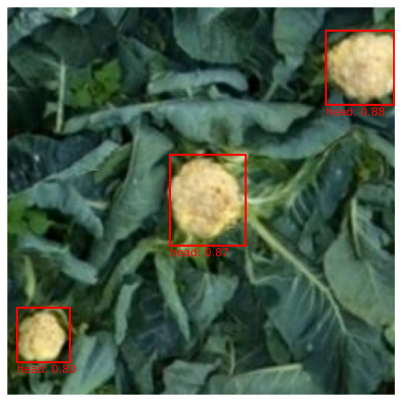

Anzahl erkannter Pflanzen: 1
Head size:  14.19 cm


In [47]:
os.chdir('/home/ab/') 
sizes = []
increments = []

# Festlegen des Pfades zum Bild
date = '2021_08_30' 
PATH_image = 'raid/GrowliFlowerD/Field2/'+date+'/'+date+'_Def_day3_88.jpg'   #  !!!!!!!!! Den Pfad entsprechend bearbeiten !!!!!!!!!
# Festlegen des Pfades zum Modell
PATH_model = 'models/plant_segmentation/model18.pth'
# Vorhersage der Pflanzengröße
plant_size = predict_plant_size(PATH_image)
# Erhalten der Kopffläche
head_area = get_head_area(PATH_image)
# Überprüfen, ob ein Kopf erkannt wurde
if head_area != 0:
    # Extrahieren des Dateinamens aus dem Bildpfad
    filename = os.path.splitext(os.path.basename(PATH_image))[0]
    # Erhalten der höchsten Experimentdatei
    exp = get_highest_exp_file('yolov5/runs/detect/')
    # Festlegen des Pfades zur Label-Datei
    label_file_path = 'yolov5/runs/detect/'+exp+'/labels/'+filename+'.txt'
    # Erhalten der zentralen Box
    head_box = get_central_box(label_file_path, PATH_image)
    # Extrahieren der Breite der Kopf-Bounding-Box
    head_bbox_width = head_box[2]
    # Erhalten der Pflanzenbox
    plant_box = get_plant_box(PATH_image, PATH_model)
    # Umwandeln der Pflanzenbox in ein Tupel von Fließkommazahlen
    plant_box = extract_float_value_toTuple(plant_box)
    # Extrahieren der Breite der Pflanzen-Bounding-Box
    plant_bbox_width = plant_box[2]
    # Überprüfen, ob der Kopf innerhalb der Pflanzenbox liegt
    if is_inside(plant_box, head_box):
        # Berechnen der Kopfgröße basierend auf den Dimensionen der Bounding-Box und der Pflanzengröße
        head_size = get_head_size(plant_size, plant_bbox_width, head_bbox_width)
        # Hinzufügen der berechneten Kopfgröße zur Liste
        sizes.append(head_size)
    else:
        # Ausgabe einer Fehlermeldung, wenn der Kopf nicht innerhalb der Pflanzenbox liegt
        print('################### Kopf ist nicht innerhalb der Pflanzenbox für ', date, ' ###################')
else:
    # Ausgabe einer Fehlermeldung, wenn kein Kopf erkannt wurde
    print('################### Kein Kopf erkannt für ', date, ' ###################')

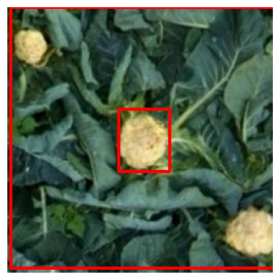

: 

In [48]:
#PATH_image = 'raid/GrowliFlowerD/Field2/2021_08_23/2021_08_23_Def_day1_14.jpg'
plot_2_boxes_on_image(PATH_image, plant_box, head_box)